## Description

### Problem

#### Objective:
Energy savings is one of the important area of focus our current world. Energy savings has two key elements:

* Forecasting future energy usage without improvements
* Forecasting energy use after a specific set of improvements have been implemented

Once we have implemented a set of improvements, the value of energy efficiency improvements can be challenging as there's no way to truly know **how much energy a building would have used without the improvements**. The best we can do is to build counterfactual models. 

We build these counterfactual models across four energy types:
* **chilled water**
* **electricity**
* **hot water**
* **steam**

based on historic usage rates and observed weather.

### Data

#### Dataset:
The dataset includes three years of hourly meter readings from over one thousand buildings at several different sites around the world.

##### train.csv

* `building_id` - Foreign key for the building metadata.
* `meter` - The meter id code. Read as {0: electricity, 1: chilledwater, 2: steam, 3: hotwater}. Not every building has all meter types.
* `timestamp` - When the measurement was taken
* `meter_reading` - The target variable. Energy consumption in kWh (or equivalent). Note that this is real data with measurement error, which we expect will impose a baseline level of modeling error.

##### building_meta.csv

* `site_id` - Foreign key for the weather files.
* `building_id` - Foreign key for training.csv
* `primary_use` - Indicator of the primary category of activities for the building based on EnergyStar property type definitions
* `square_feet` - Gross floor area of the building
* `year_built` - Year building was opened
* `floor_count` - Number of floors of the building

##### weather_[train/test].csv

Weather data from a meteorological station as close as possible to the site.

* `site_id`
* `air_temperature` - Degrees Celsius
* `cloud_coverage` - Portion of the sky covered in clouds, in oktas
* `dew_temperature` - Degrees Celsius
* `precip_depth_1_hr` - Millimeters
* `sea_level_pressure` - Millibar/hectopascals
* `wind_direction` - Compass direction (0-360)
* `wind_speed` - Meters per second

##### test.csv

The submission files use row numbers for ID codes in order to save space on the file uploads. test.csv has no feature data; it exists so you can get your predictions into the correct order.

* `row_id` - Row id for your submission file
* `building_id` - Building id code
* `meter` - The meter id code
* `timestamp` - Timestamps for the test data period

### Imports

In [1]:
# work with data
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

# plotting issues
import seaborn as sns
from matplotlib import pyplot as plt

# statistics calculation
from statistics import median

# ML models
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_log_error

random_state = 42

# technical issues
import os
%matplotlib inline

## Data Preprocessing

### Data Loading

In [2]:
%%time
building_metadata = pd.read_csv('data' + os.sep + 'building_metadata.csv')

Wall time: 78.6 ms


In [3]:
%%time
train_data = pd.read_csv('data' + os.sep + 'train.csv')

Wall time: 16 s


In [4]:
%%time
test_data = pd.read_csv('data' + os.sep + 'test.csv')

Wall time: 31.4 s


### Data Cleaning

In [5]:
building_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1449 entries, 0 to 1448
Data columns (total 6 columns):
site_id        1449 non-null int64
building_id    1449 non-null int64
primary_use    1449 non-null object
square_feet    1449 non-null int64
year_built     675 non-null float64
floor_count    355 non-null float64
dtypes: float64(2), int64(3), object(1)
memory usage: 68.0+ KB


In [6]:
floor_count_median = building_metadata[['primary_use', 'floor_count']].groupby(['primary_use']).median()
year_built_median = building_metadata[['primary_use', 'year_built']].groupby(['primary_use']).median()

In [7]:
floor_count_median.loc['Food sales and service'] = 1.0
floor_count_median.loc['Religious worship'] = 2.0
floor_count_median.loc['Services'] = 1.0
floor_count_median

,floor_count
primary_use,
Education,4.0
Entertainment/public assembly,1.0
Food sales and service,1.0
Healthcare,1.0
Lodging/residential,7.0
Manufacturing/industrial,2.0
Office,2.5
Other,1.0
Parking,2.0


In [8]:
year_built_median.loc['Services'] = year_built_median['year_built'].median()
year_built_median

,year_built
primary_use,
Education,1966.0
Entertainment/public assembly,1976.0
Food sales and service,2012.0
Healthcare,2000.0
Lodging/residential,1975.0
Manufacturing/industrial,1969.0
Office,1976.0
Other,1980.0
Parking,2003.0


In [9]:
for index in building_metadata.index:
    if np.isnan(building_metadata.loc[index]['floor_count']):
        building_metadata.set_value(index, 'floor_count', floor_count_median.loc[building_metadata.loc[index]['primary_use']].values[0])
    if np.isnan(building_metadata.loc[index]['year_built']):
        building_metadata.set_value(index, 'year_built', year_built_median.loc[building_metadata.loc[index]['primary_use']].values[0])
building_metadata.info()

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  This is separate from the ipykernel package so we can avoid doing imports until
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  """


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1449 entries, 0 to 1448
Data columns (total 6 columns):
site_id        1449 non-null int64
building_id    1449 non-null int64
primary_use    1449 non-null object
square_feet    1449 non-null int64
year_built     1449 non-null float64
floor_count    1449 non-null float64
dtypes: float64(2), int64(3), object(1)
memory usage: 68.0+ KB


In [10]:
del floor_count_median
del year_built_median

In [11]:
# def CreateMeanMeterReading(train_data, buildings_number):
#     new_columns = list(train_data.columns)
#     new_columns.append('meter_reading_mean')

#     train = pd.DataFrame(columns=new_columns)

#     building_ids = train_data['building_id'].unique()[1:buildings_number]
#     train_data_cutted = train_data[train_data['building_id'] == train_data['building_id'].unique()[0]]
#     for building_id in building_ids:
#         train_data_cutted = train_data_cutted.append(train_data[train_data['building_id'] == building_id], ignore_index=True)
    
#     for building_id in train_data_cutted['building_id'].unique():
#         buildingID = train_data_cutted[train_data_cutted['building_id'] == building_id]
#         for month_id in buildingID['month'].unique():
#             buildingIDmonthID = buildingID[buildingID['month'] == month_id]
#             for day_id in buildingIDmonthID['day'].unique():
#                 buildingIDmonthIDdayID = buildingIDmonthID[buildingIDmonthID['day'] == day_id]
#                 train = train.append(buildingIDmonthIDdayID[0:1], ignore_index=True)
#                 train.set_value(train.shape[0]-1, 'meter_reading_mean', buildingIDmonthIDdayID['meter_reading'].mean())
    
#     train = train.drop(['hour', 'year', 'building_id', 'floor_count', 'meter_reading', 'meter'], axis=1)
#     train['primary_use'] = LabelEncoder().fit_transform(train['primary_use'])
#     train = train.apply(pd.to_numeric)
#     return train

## Exploratory Data Analysis

### Data Cleaning & Simple Statistics

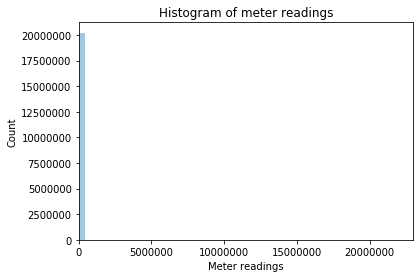

In [12]:
plt.ticklabel_format(axis='both', style='sci', scilimits=(0,10))
plt.title("Histogram of meter readings")

g = sns.distplot(train_data['meter_reading'], kde = False)

plt.xlabel("Meter readings")
plt.ylabel("Count")
g.set_xlim(xmin=0)
g.set_ylim(ymin=0);

As we can see, data contains several really big values in meter readings. We consider them as **outliers**. To tackle them we are trimming our data to 95-percentile in meter readings.

In [13]:
train_data = train_data[train_data['meter_reading'] < train_data['meter_reading'].quantile(.95)]

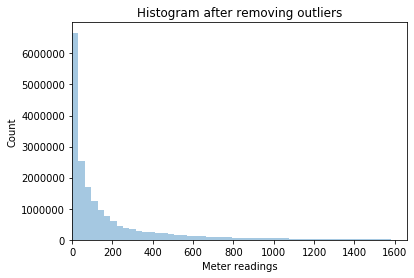

In [14]:
plt.ticklabel_format(axis='both', style='sci', scilimits=(-10,10))
plt.title("Histogram after removing outliers")

g = sns.distplot(train_data['meter_reading'], kde = False)

plt.xlabel("Meter readings")
plt.ylabel("Count")
g.set_xlim(xmin=0)
g.set_ylim(ymin=0);

In [15]:
def ConvertDate(data):
    # Convert date to datetime format
    data['timestamp'] = pd.to_datetime(data['timestamp'])
    
    # Extract and store month, day and hour
    data['month'] = data['timestamp'].dt.month
    data['day'] = data['timestamp'].dt.day
    data['hour'] = data['timestamp'].dt.hour
    
    data.drop(['timestamp'], axis=1, inplace=True)

In [16]:
ConvertDate(train_data)
ConvertDate(test_data)

If we take a look at median `meter_reading` vs `hour` of the day, we can notice that the majority of energy is consumed during the day.

In [17]:
median_hour = train_data.groupby(['hour']).median()
median_hour.reset_index(inplace=True)

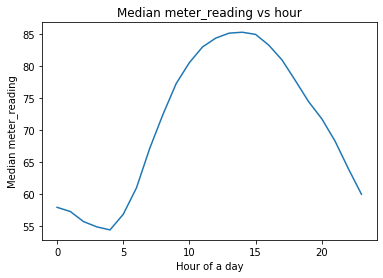

In [18]:
sns.lineplot(x='hour', y='meter_reading', data=median_hour)

plt.title("Median meter_reading vs hour")
plt.xlabel("Hour of a day")
plt.ylabel("Median meter_reading")

g.set_xlim(xmin=0)
g.set_ylim(ymin=0);

Speaking about most energy consuming `month`s, **June-September** is the time period when `meter_reading`s are on the highest level.

In [19]:
median_month = train_data.groupby(['month']).median()
median_month.reset_index(inplace=True)

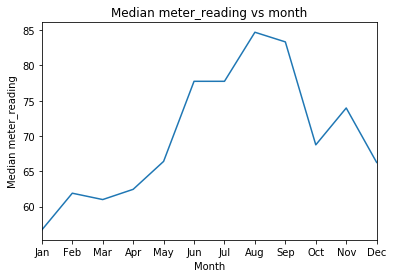

In [20]:
g = sns.lineplot(x='month', y='meter_reading', data=median_month)

plt.title("Median meter_reading vs month")
plt.xlabel("Month")
plt.ylabel("Median meter_reading")

mnths_tpl = ('Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec')
g.set_xticks(list(range(1, 13)))
g.set_xticklabels(mnths_tpl)

g.set_xlim(xmin=1, xmax=12);

In [21]:
del median_hour
del median_month

In [22]:
train_data = train_data.join(building_metadata.set_index('building_id'), on='building_id', how='inner')
train_data.head()

,building_id,meter,meter_reading,month,day,hour,site_id,primary_use,square_feet,year_built,floor_count
0,0,0,0.0,1,1,0,0,Education,7432,2008.0,4.0
2301,0,0,0.0,1,1,1,0,Education,7432,2008.0,4.0
4594,0,0,0.0,1,1,2,0,Education,7432,2008.0,4.0
6893,0,0,0.0,1,1,3,0,Education,7432,2008.0,4.0
9189,0,0,0.0,1,1,4,0,Education,7432,2008.0,4.0


In [23]:
test_data = test_data.join(building_metadata.set_index('building_id'), on='building_id', how='inner')
test_data.head()

,row_id,building_id,meter,month,day,hour,site_id,primary_use,square_feet,year_built,floor_count
0,0,0,0,1,1,0,0,Education,7432,2008.0,4.0
129,129,0,0,1,1,1,0,Education,7432,2008.0,4.0
258,258,0,0,1,1,2,0,Education,7432,2008.0,4.0
387,387,0,0,1,1,3,0,Education,7432,2008.0,4.0
516,516,0,0,1,1,4,0,Education,7432,2008.0,4.0


In [24]:
del building_metadata

In [25]:
number_by_categories = train_data.groupby(['primary_use']).count()
number_by_categories

,building_id,meter,meter_reading,month,day,hour,site_id,square_feet,year_built,floor_count
primary_use,,,,,,,,,,
Education,7630579,7630579,7630579,7630579,7630579,7630579,7630579,7630579,7630579,7630579
Entertainment/public assembly,2207846,2207846,2207846,2207846,2207846,2207846,2207846,2207846,2207846,2207846
Food sales and service,108430,108430,108430,108430,108430,108430,108430,108430,108430,108430
Healthcare,340718,340718,340718,340718,340718,340718,340718,340718,340718,340718
Lodging/residential,2078864,2078864,2078864,2078864,2078864,2078864,2078864,2078864,2078864,2078864
Manufacturing/industrial,121016,121016,121016,121016,121016,121016,121016,121016,121016,121016
Office,4185981,4185981,4185981,4185981,4185981,4185981,4185981,4185981,4185981,4185981
Other,236903,236903,236903,236903,236903,236903,236903,236903,236903,236903
Parking,209273,209273,209273,209273,209273,209273,209273,209273,209273,209273


In [26]:
number_by_categories_series = number_by_categories['meter_reading']
number_by_categories_series = number_by_categories_series.sort_values(ascending=False)

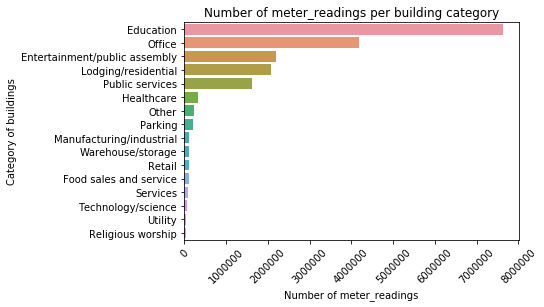

In [27]:
g = sns.barplot(x=number_by_categories_series.values, y=number_by_categories_series.index)

plt.title("Number of meter_readings per building category")
plt.xlabel("Number of meter_readings")
plt.ylabel("Category of buildings")
plt.xticks(rotation=45);

According to the barplot, most readings are obtained for the **"Education"** type buildings, consequently it is likely that better results will be achieved for buildings of this type.

In [28]:
del number_by_categories
del number_by_categories_series

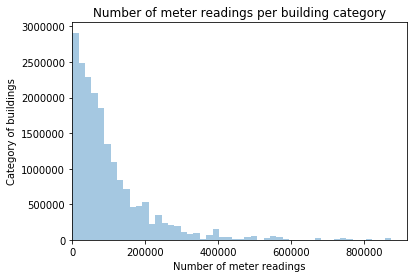

In [29]:
g = sns.distplot(train_data['square_feet'], kde = False)

plt.title("Number of meter readings per building category")
plt.xlabel("Number of meter readings")
plt.ylabel("Category of buildings")

g.set_xlim(xmin=0)
g.set_ylim(ymin=0);

Total area of buildings is skewed but there are no isolated outliers. There are groups of buildings with big area:

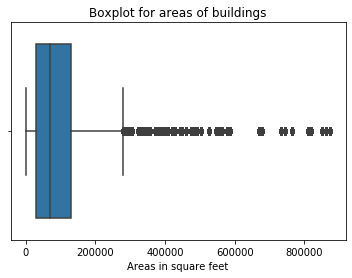

In [30]:
g = sns.boxplot(train_data['square_feet'])

plt.title("Boxplot for areas of buildings")
plt.xlabel("Areas in square feet");

Dataset contains **4 types** of `meter` but number of readings might be to different between those types.

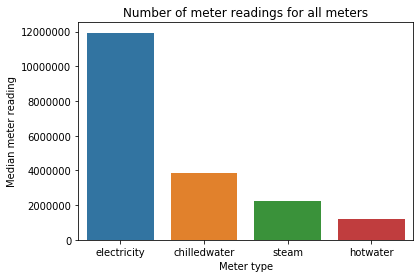

In [31]:
plt.ticklabel_format(axis='both', style='sci', scilimits=(-10,10))
g = sns.countplot(train_data['meter'])

plt.title("Number of meter readings for all meters")
plt.xlabel("Meter type")
plt.ylabel("Median meter reading")

meter_tpl = ('electricity', 'chilledwater', 'steam', 'hotwater')
g.set_xticks(list(range(0, 4)))
g.set_xticklabels(meter_tpl);

There are more readings of **electricity** than readings of all other meter types, therefore our main priority will be to predict electricity readings.

### Statistics

In [32]:
def Encode(data, feature, encoder):
    data[feature] = encoder.transform(data[feature])

In [33]:
label_encoder = LabelEncoder()
feature = 'primary_use'
label_encoder.fit(train_data[feature])
Encode(train_data, feature, label_encoder)
Encode(test_data, feature, label_encoder)

Take a look at **correlation** of features with our target `meter_reading`

In [34]:
correlation = train_data.corr()
correlation.head()

,building_id,meter,meter_reading,month,day,hour,site_id,primary_use,square_feet,year_built,floor_count
building_id,1.000000,0.197652,0.114828,0.019296,-0.000388,0.000923,0.980673,0.059921,0.073179,-0.071803,-0.096206
meter,0.197652,1.000000,0.154858,0.010079,0.000111,0.000238,0.228114,-0.082682,0.113018,0.005533,0.060753
meter_reading,0.114828,0.154858,1.000000,0.029174,0.003368,0.025097,0.126673,-0.083044,0.399734,0.088824,0.070158
month,0.019296,0.010079,0.029174,1.000000,0.010611,-0.000730,0.019023,-0.001398,-0.002573,-0.005064,0.002715
day,-0.000388,0.000111,0.003368,0.010611,1.000000,0.000259,-0.000454,0.000399,-0.001434,0.000106,-0.000788


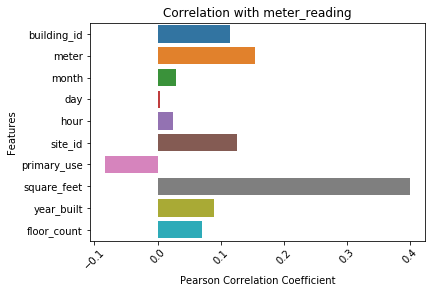

In [35]:
correlation_series = correlation['meter_reading'].drop(['meter_reading'])

g = sns.barplot(x=correlation_series.values, y=correlation_series.index)

plt.title("Correlation with meter_reading")
plt.xticks(rotation=45)
plt.xlabel("Pearson Correlation Coefficient")
plt.ylabel("Features");

No strongly correlated features.

In [36]:
del correlation
del correlation_series

Inspect **correlation of different powers** of features (e.g. $floor\_count^2$) with the **electricity target** (`meter` == 0).

In [37]:
def SplitIntoEnergyTypes(data):
    data_electricity = data[data['meter'] == 0].drop(['building_id', 'meter'], axis=1)
    data_chilledWater = data[data['meter'] == 1].drop(['building_id', 'meter'], axis=1)
    data_steam = data[data['meter'] == 2].drop(['building_id', 'meter'], axis=1)
    data_hotWater = data[data['meter'] == 3].drop(['building_id', 'meter'], axis=1)
    return data_electricity, data_chilledWater, data_steam, data_hotWater

In [38]:
train_data_electricity, train_data_chilledWater, train_data_steam, train_data_hotWater = SplitIntoEnergyTypes(train_data)

In [39]:
test_data_electricity, test_data_chilledWater, test_data_steam, test_data_hotWater = SplitIntoEnergyTypes(test_data)

In [40]:
train_data_electricity.head()

,meter_reading,month,day,hour,site_id,primary_use,square_feet,year_built,floor_count
0,0.0,1,1,0,0,0,7432,2008.0,4.0
2301,0.0,1,1,1,0,0,7432,2008.0,4.0
4594,0.0,1,1,2,0,0,7432,2008.0,4.0
6893,0.0,1,1,3,0,0,7432,2008.0,4.0
9189,0.0,1,1,4,0,0,7432,2008.0,4.0


In [41]:
test_data_electricity.head()

,row_id,month,day,hour,site_id,primary_use,square_feet,year_built,floor_count
0,0,1,1,0,0,0,7432,2008.0,4.0
129,129,1,1,1,0,0,7432,2008.0,4.0
258,258,1,1,2,0,0,7432,2008.0,4.0
387,387,1,1,3,0,0,7432,2008.0,4.0
516,516,1,1,4,0,0,7432,2008.0,4.0


In [42]:
del train_data
del test_data

In [43]:
def FeaturesTargetSplit(data):
    target = data['meter_reading']
    features = data.drop(['meter_reading'], axis=1)
    
    return features, target

In [44]:
features_electricity, target_electricity = FeaturesTargetSplit(train_data_electricity)
features_chilledWater, target_chilledWater = FeaturesTargetSplit(train_data_chilledWater)
features_steam, target_steam = FeaturesTargetSplit(train_data_steam)
features_hotWater, target_hotWater = FeaturesTargetSplit(train_data_hotWater)

In [45]:
del train_data_electricity
del train_data_chilledWater
del train_data_steam
del train_data_hotWater

In [46]:
features_electricity.head()

,month,day,hour,site_id,primary_use,square_feet,year_built,floor_count
0,1,1,0,0,0,7432,2008.0,4.0
2301,1,1,1,0,0,7432,2008.0,4.0
4594,1,1,2,0,0,7432,2008.0,4.0
6893,1,1,3,0,0,7432,2008.0,4.0
9189,1,1,4,0,0,7432,2008.0,4.0


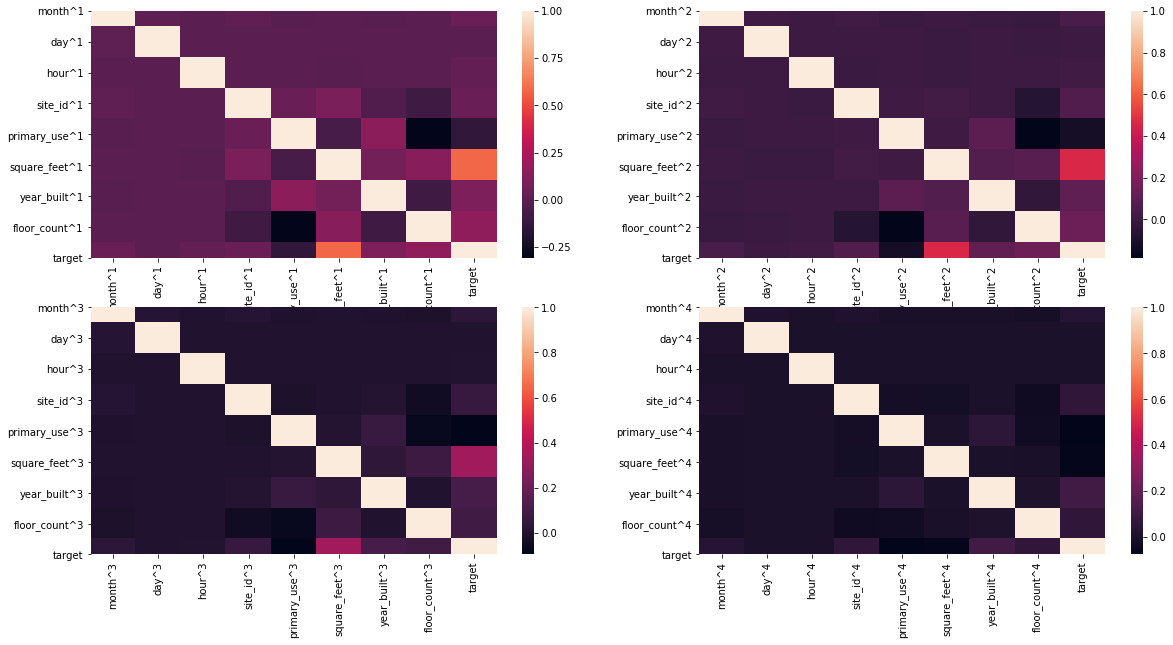

In [49]:
plt.figure(figsize=(20,10))
 
list_of_powered_features = []
features_corr_dict = {}
 
for i in range(1, 5):
    new_columns = []
    features_powered = features_electricity ** i
    
    # give columns appropriate names
    for column in features_powered.columns:
        new_columns.append(column + '^{0}'.format(i))
    features_powered.columns = new_columns
 
    list_of_powered_features.append(features_powered)
    
    data_2power = features_powered
    data_2power['target'] = target_electricity
    correlation = data_2power.corr()
    
    # add values to the dictionary of feature correlation
    target_column = correlation['target']
    for j in range(target_column.shape[0]):
        key = target_column.index.values[j]
        if key != 'target':
            value = target_column.iloc[j]
            features_corr_dict[key] = value
 
    plt.subplot(2,2,i)
    ax = sns.heatmap(correlation)

In [50]:
sorted_features_corr_dict = sorted(features_corr_dict.items(), key=lambda kv: kv[1])
sorted_features_corr_dict.reverse()

**Top 5 of correlating features**

In [51]:
top = []
for i in range(1, 6):
    feature_name = sorted_features_corr_dict[i][0]
    top.append(feature_name)
    
print(top)

['square_feet^2', 'square_feet^3', 'floor_count^1', 'floor_count^2', 'year_built^4']


## Metrics

The evaluation metric for this competition is **Root Mean Squared Logarithmic Error (RMSLE)**.

The RMSLE is calculated as $RMSLE = \sqrt{\frac{1}{n} \sum_{i=1}^{n}\left(\log \left(p_{i}+1\right)-\log \left(a_{i}+1\right)\right)^{2}}$

We have chosen RMSLE not to penalize huge differences in the predicted and the actual values when both predicted and true values are huge numbers (in this dataset they might go up to around 7 thousand kw/h). What is more, for this paticular problem overestimating meter readings is better than underestimating them since the goal is to find how much imporovements of buildings helped reduce their energy consumption. In this case again RMSLE is more appropriate than MSE.

## ML models

### Preprocessing

In [ ]:
pipe_ridge = Pipeline(steps=[
    ('model', Ridge(random_state=random_state))
])

pipe_lasso = Pipeline(steps=[
    ('model', Lasso(random_state=random_state))
])

### Linear model

In [ ]:
model = Ridge(alpha=0.1, random_state=random_state)

def BasePredict(model, features, target, test):
    model.fit(features, target)
    return model.predict(test.drop(['row_id'], axis=1))

In [ ]:
# pred_electricity = SuperPredict(features_electricity, target_electricity, test_data_electricity.drop(['row_id'], axis=1), pipes)

In [ ]:
pred_electricity = BasePredict(model, features_electricity, target_electricity, test_data_electricity)
pred_chilledWater = BasePredict(model, features_chilledWater, target_chilledWater, test_data_chilledWater)
pred_steam = BasePredict(model, features_steam, target_steam, test_data_steam)
pred_hotWater = BasePredict(model, features_hotWater, target_hotWater, test_data_hotWater)

## Results Analyzing

### Results Table Forming

In [ ]:
test_data_electricity['meter_reading'] = pred_electricity
test_data_electricity.drop(['site_id', 'primary_use', 'square_feet', 'year_built', 'floor_count', 'month', 'day', 'hour'], axis=1, inplace=True)

test_data_chilledWater['meter_reading'] = pred_chilledWater
test_data_chilledWater.drop(['site_id', 'primary_use', 'square_feet', 'year_built', 'floor_count', 'month', 'day', 'hour'], axis=1, inplace=True)

test_data_steam['meter_reading'] = pred_steam
test_data_steam.drop(['site_id', 'primary_use', 'square_feet', 'year_built', 'floor_count', 'month', 'day', 'hour'], axis=1, inplace=True)

test_data_hotWater['meter_reading'] = pred_hotWater
test_data_hotWater.drop(['site_id', 'primary_use', 'square_feet', 'year_built', 'floor_count', 'month', 'day', 'hour'], axis=1, inplace=True)

In [ ]:
answers = pd.concat([test_data_electricity, test_data_chilledWater, test_data_steam, test_data_hotWater])

In [ ]:
answers.sort_index(inplace=True)

In [ ]:
def TruncFour(number):
    return int(number * 10000) / 10000.0
answers['meter_reading'] = answers['meter_reading'].apply(TruncFour)

In [ ]:
answers.head()

In [ ]:
answers.to_csv('./submission.csv', sep=',', index=False)

### Comparison of models

#### TO DO:

* Compare results of Linear and Classifier models (take test scores from kaggle)
* Write conclusion